In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

import cv2


from matplotlib import pyplot as plt

import math

import random 

from keras.layers import Input, Flatten, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

from keras.models import Model
from keras.optimizers import Adam

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


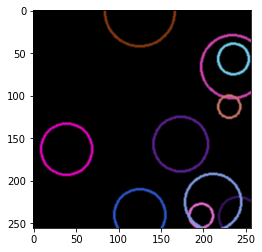

In [2]:
#-----------------------------------------------------------------------------------------------------
def GenerateInputFrame(frame,codes):
    
    for ic in range(0, len(codes), 6):
            codex = codes[ic]
            codey = codes[ic+1]
            coder = codes[ic+2]
            clr = codes[ic+3]
            clg = codes[ic+4]
            clb = codes[ic+5]
            cv2.circle(frame, (int(codex*255),int(codey*255)), int(coder*50), (clr,clg,clb), thickness=2)
    return frame
#-----------------------------------------------------------------------------------------------------
def MakeBatch(batch_size):
    X = np.zeros((batch_size, 256, 256, 3))
    Y = np.zeros((batch_size, 256, 256, 3))
    for ib in range (0, batch_size):
        codes = []
        ncircles = 10
        for icir in range(0,ncircles):
            x = np.random.randint(0,10000)/10000
            y = np.random.randint(0,10000)/10000
            r = np.random.randint(0,10000)/10000
            clr = np.random.randint(0,10000)/10000
            clg = np.random.randint(0,10000)/10000
            clb = np.random.randint(0,10000)/10000
            codes.append(x)
            codes.append(y)
            codes.append(r)
            codes.append(clr)
            codes.append(clg)
            codes.append(clb)
            
            GenerateInputFrame(X[ib,:,:,:], codes)
            GenerateInputFrame(Y[ib,:,:,:], codes)
    return X,Y
#-----------------------------------------------------------------------------------------------------
# Generator function 
def Generator(batch_size):
    while True:
        X, Y = MakeBatch(batch_size)
        yield X, Y
#-----------------------------------------------------------------------------------------------------

X,Y = MakeBatch(10)   
         
plt.imshow(X[9,:,:], cmap = 'gray', interpolation = 'bicubic')

plt.show()
        
    
            
       


In [6]:
#-------------------------------  Model ----------------------------------------

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(256, 256, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)



encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)



x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
#autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

autoencoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 8)         584       
__________

In [7]:
#autoencoder.fit(x_train, x_train,
#                epochs=50,
#                batch_size=128,
#                shuffle=True,
#                validation_data=(x_test, x_test),
#                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

results = autoencoder.fit_generator(Generator(batch_size = 50), steps_per_epoch = 200, epochs = 1)


Epoch 1/1
200/200 [==============================] - 92s 461ms/step - loss: 0.1364


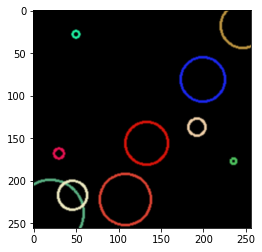

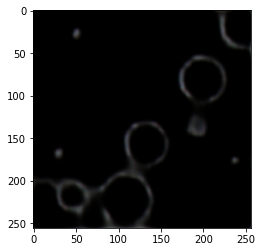

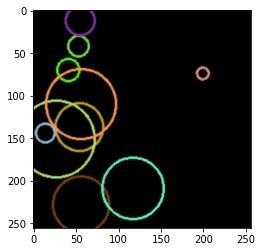

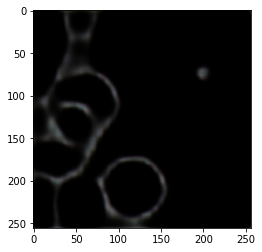

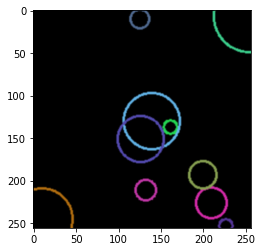

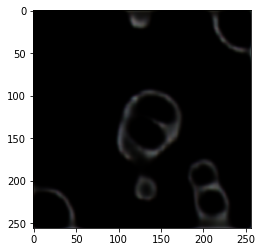

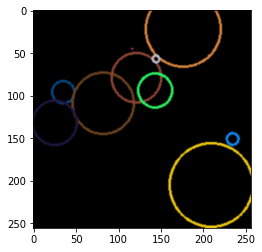

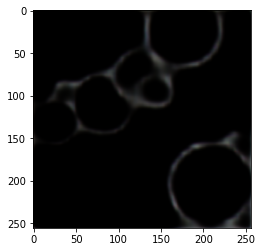

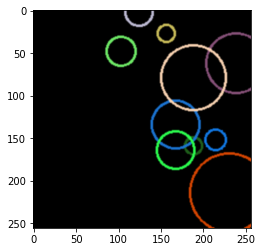

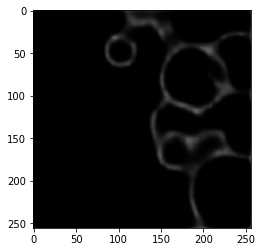

In [10]:
X,Y = MakeBatch(5)   
predictions = autoencoder.predict(X) 

for i in range(0,5):
    plt.imshow(X[i,:,:], interpolation = 'bicubic')
    plt.show()
    plt.imshow(predictions[i,:,:], interpolation = 'bicubic')
    plt.show()